In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchsr.datasets import Div2K
from torchsr.models import ninasr_b0, rcan, edsr, ninasr_b1
from torchvision.transforms.functional import to_pil_image, to_tensor
from skimage.transform import rescale, resize, downscale_local_mean

In [12]:
plt.rcParams['figure.figsize'] = [12, 12]
path = "../Dataset/Raw/sentinel-2/06-001-0007/S2B_MSIL2A_20210911T184929_N0301_R113_T10SFG_20210911T214647.npy"
path2 = "../Dataset/Raw/sentinel-2/06-025-0005/S2A_MSIL2A_20210818T181921_N0301_R127_T11SPS_20210818T224339.npy"
im = np.load(path).astype("double")
im.shape

(200, 200, 12)

<h1>Exploring the Images</h1>

Channel 1 has size (200, 200)
Has max 117.71090047393365 and min 1.7825829383886256
Channel 2 has size (200, 200)
Has max 182.33585075804544 and min 0.7760807078847997
Channel 3 has size (200, 200)
Has max 236.89884649511978 and min 0.014141526175687666
Channel 4 has size (200, 200)
Has max 115.88613861386139 and min 9.341584158415841
Channel 5 has size (200, 200)
Has max 114.98371335504886 and min 6.938110749185668
Channel 6 has size (200, 200)
Has max 110.6022110162917 and min 12.578549262994569
Channel 7 has size (200, 200)
Has max 110.56601289982888 and min 13.980189548505988
Channel 8 has size (200, 200)
Has max 104.9221272554606 and min 13.125356125356126
Channel 9 has size (200, 200)
Has max 146.8127377765253 and min 13.599760462167113
Channel 10 has size (200, 200)
Has max 182.69641672196417 and min 9.814200398142004
Channel 11 has size (200, 200)
Has max 168.67328383088346 and min 9.853765722079103
Channel 12 has size (200, 200)
Has max 181.58192911098197 and min 50.0813480534

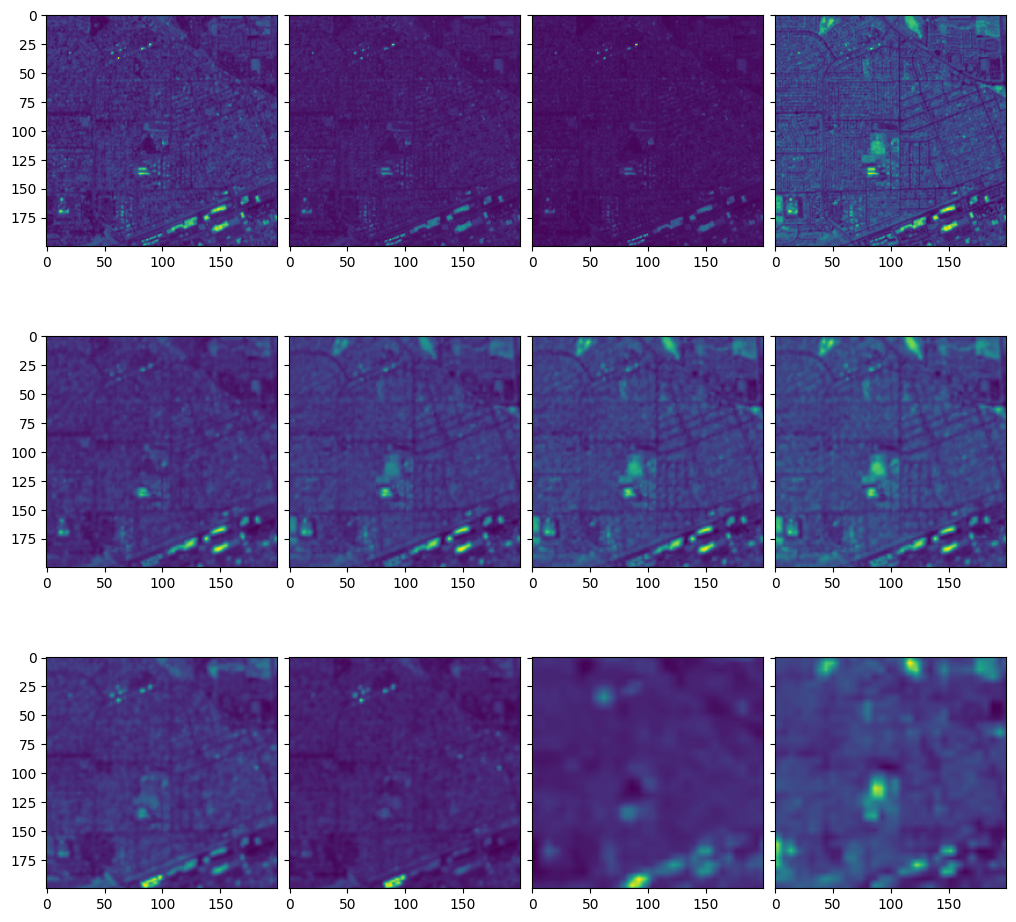

In [13]:
#Resolutions:
#10m: 0-3: 4, 3, 2, 8
#20m: 4-9: 5, 6, 7, 8a, 11, 12
#60m: 10-11: 1, 9

#Channel maxes
channel_maxes = [16880, 17744, 18032, 16160, 15699, 15469, 15195, 15796, 14197, 15078, 6599, 6885]
#Channel mins
channel_mins = [0, 1, 0, 0, 42, 1, 1, 1, 3, 8, 0, 1]


fig, ax = plt.subplots(3, 4, sharex="row", sharey="row")
for i in range(12):
    this_im = im[:,:,i]
    this_im = 255.0 * (this_im - channel_mins[i]) / (channel_maxes[i] - channel_mins[i])
    print("Channel", i+1, "has size", this_im.shape)
    print("Has max", np.max(this_im), "and min", np.min(this_im))
    ax[i // 4, i % 4].imshow(this_im)
    ax[i // 4, i % 4].tick_params(top=False, labeltop=False)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.05, 
                    hspace=0.01)

High res has shape (200, 200)
Low res has shape (100, 100)


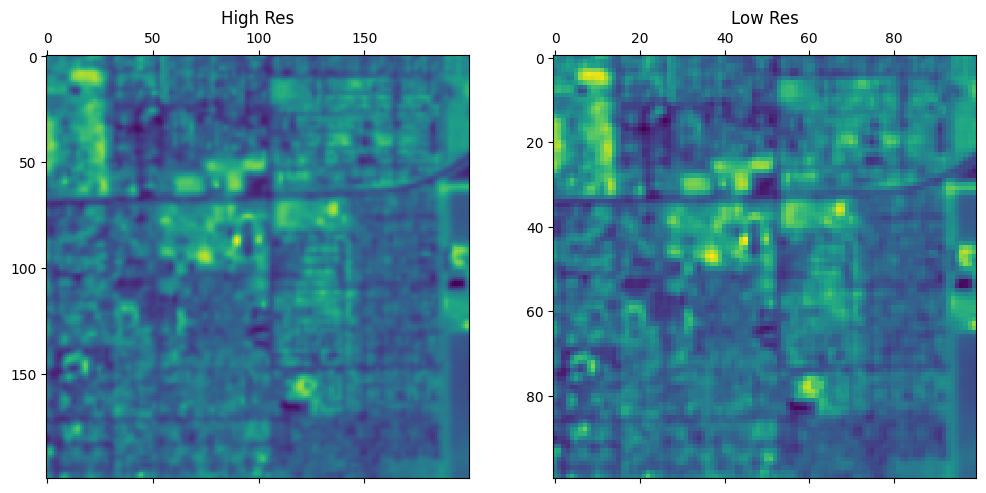

In [17]:
channel = 9
hr = im[:, :, channel]
lr = rescale(hr, 0.5)

fig, ax = plt.subplots(1, 2)
ax[0].matshow(hr)
ax[0].set_title("High Res")
print("High res has shape", hr.shape)
ax[1].matshow(lr)
ax[1].set_title("Low Res")
print("Low res has shape", lr.shape)

<h1>Out of the box comparison</h1>

Text(0.5, 1.0, 'Nina b1 (1m parameters)')

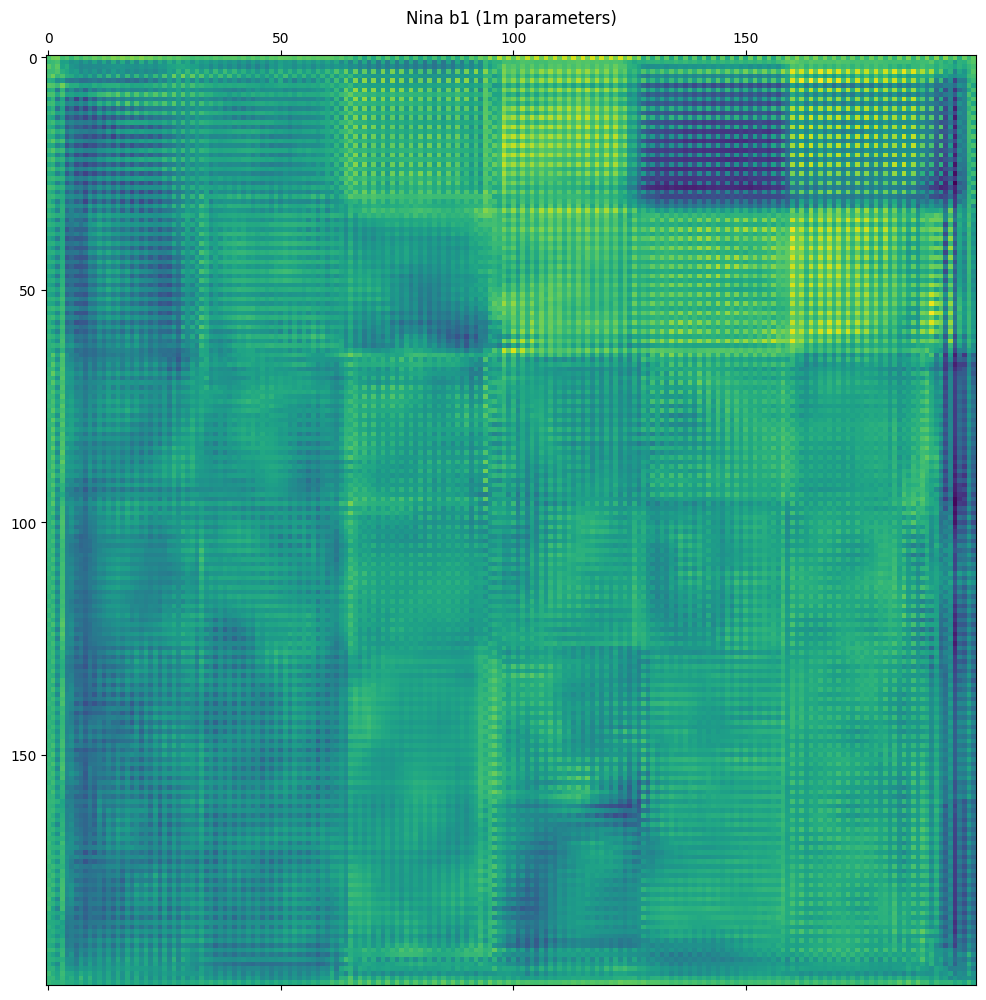

In [18]:
model = ninasr_b1(scale=2, pretrained=True).double()
lr_t = to_tensor(lr).unsqueeze(0)
sr_t = model(lr_t).squeeze(0)
nina_out = sr_t.detach().numpy()
plt.matshow(nina_out[0, :, :])
plt.title("Nina b1 (1m parameters)")

Text(0.5, 1.0, 'RCAN (15m parameters)')

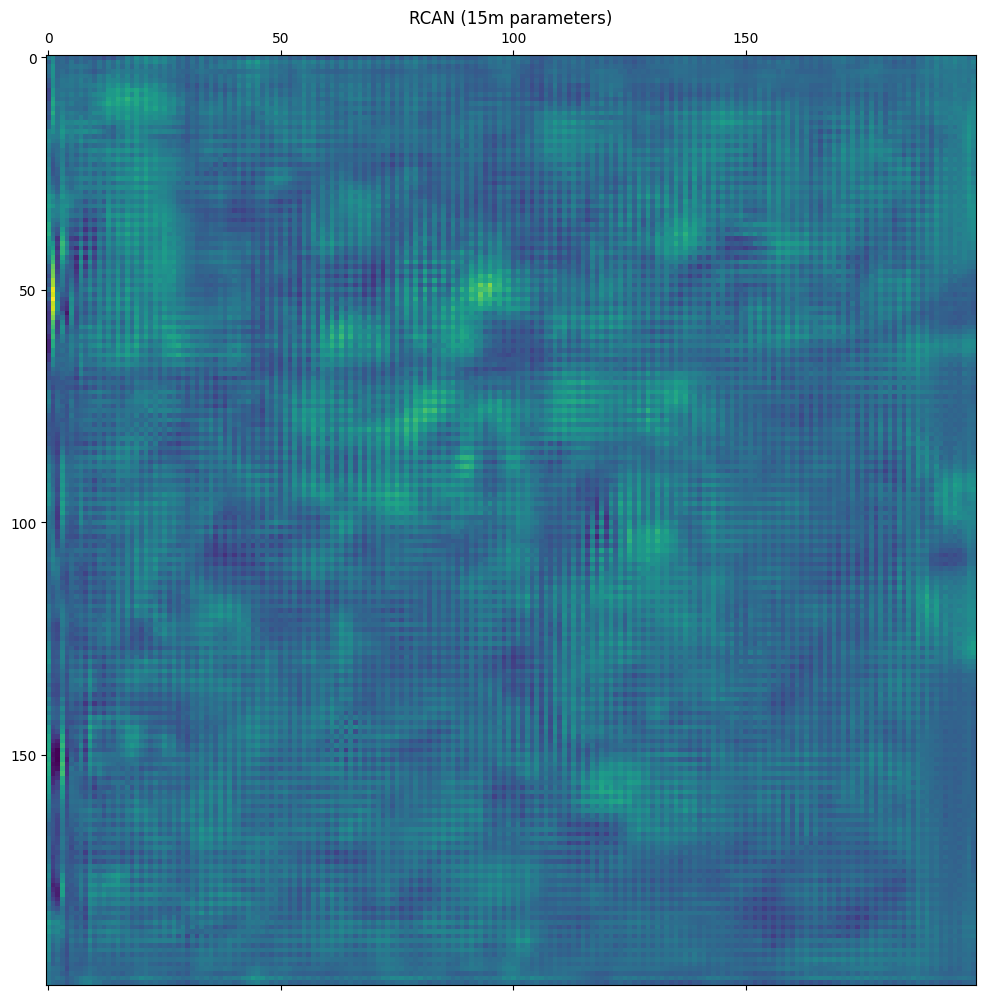

In [19]:
lr_3 = np.dstack((lr, lr, lr))
model = rcan(scale=2, pretrained=True).double()
lr_t = to_tensor(lr_3).unsqueeze(0)
sr_t = model(lr_t).squeeze(0)
rcan_out = sr_t.detach().numpy()
plt.matshow(rcan_out[0, :, :])
plt.title("RCAN (15m parameters)")

Text(0.5, 1.0, 'EDSR (40m parameters)')

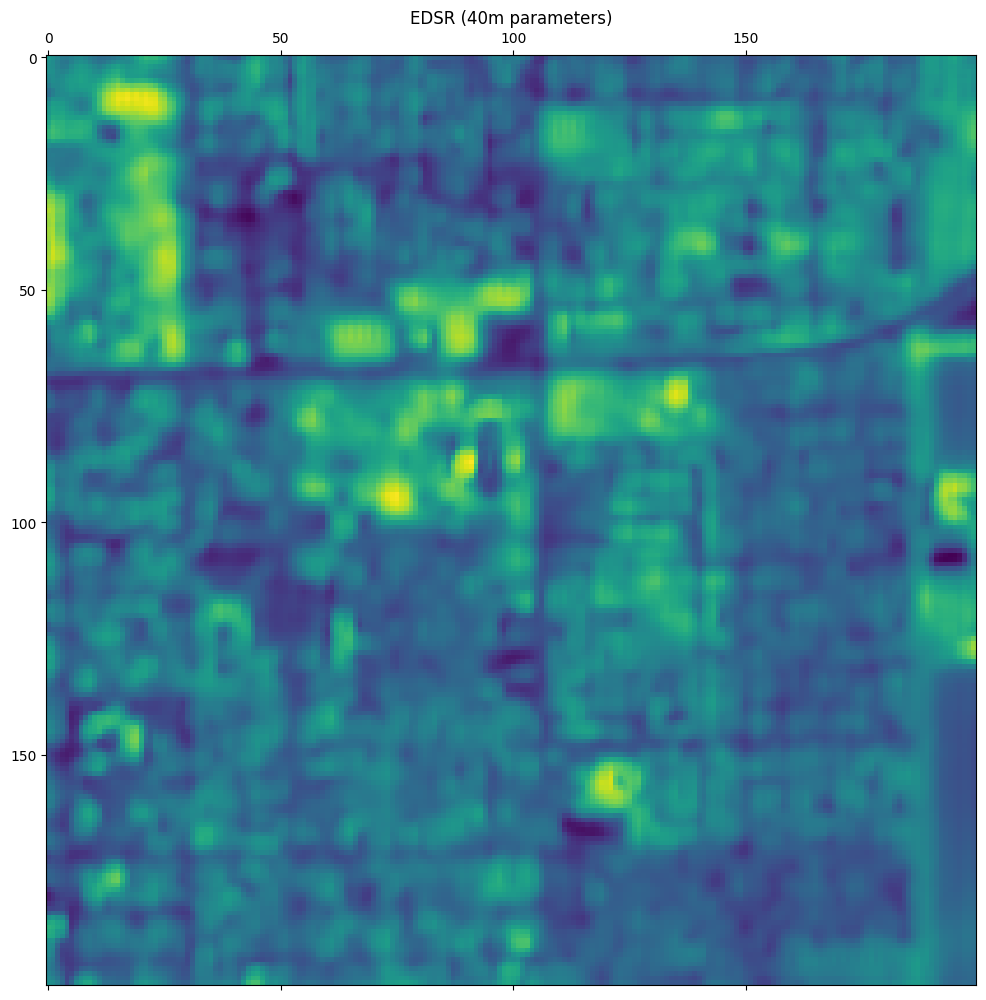

In [20]:
lr_3 = np.dstack((lr, lr, lr))
model = edsr(scale=2, pretrained=True).double()
lr_t = to_tensor(lr_3).unsqueeze(0)
sr_t = model(lr_t).squeeze(0)
edsr_out = sr_t.detach().numpy()
plt.matshow(edsr_out[0, :, :])
plt.title("EDSR (40m parameters)")

Text(0.5, 1.0, 'EDSR')

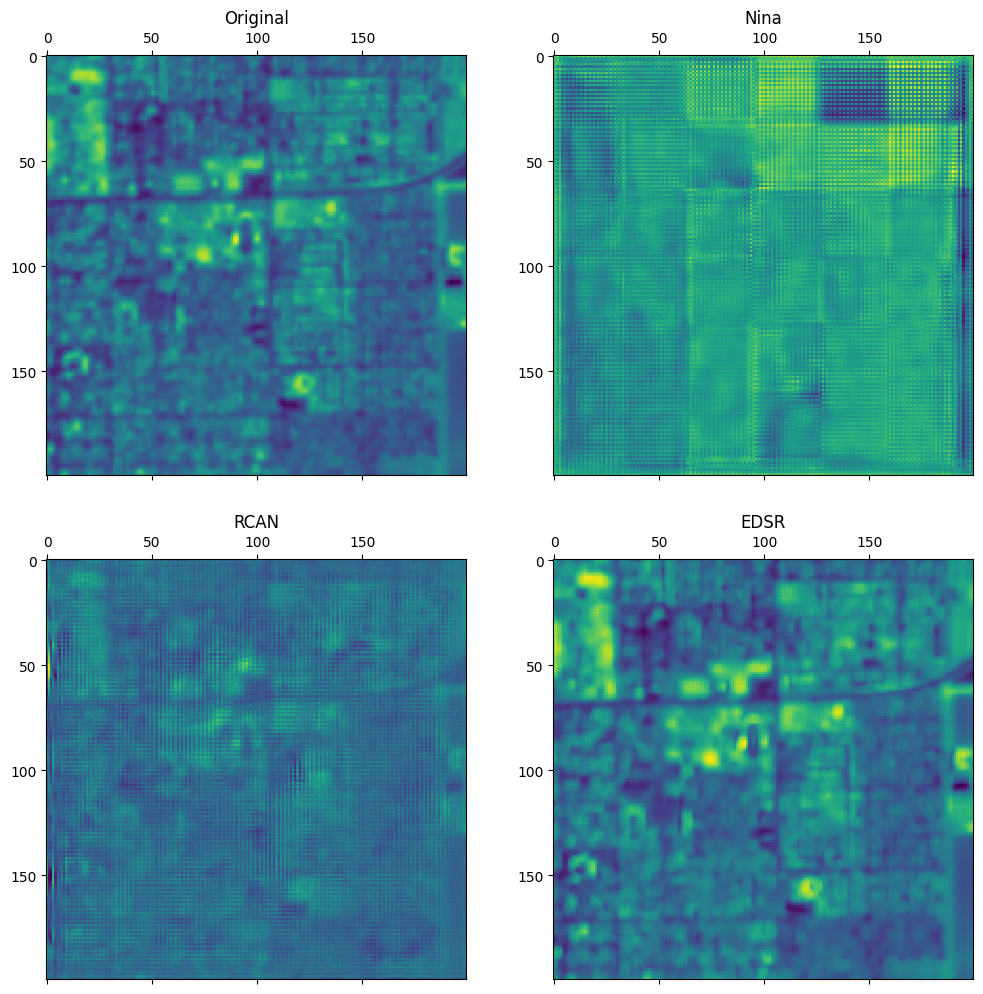

In [21]:
fig, ax = plt.subplots(2, 2)
ax[0, 0].matshow(hr)
ax[0, 0].set_title("Original")
ax[0, 1].matshow(nina_out[0, :, :])
ax[0, 1].set_title("Nina")
ax[1, 0].matshow(rcan_out[0, :, :])
ax[1, 0].set_title("RCAN")
ax[1, 1].matshow(edsr_out[0, :, :])
ax[1, 1].set_title("EDSR")

<h1>Transfer Learning</h1>

<h3>Nina B1</h3>

In [22]:
def psnr(im1, im2):
    sq_diff = np.square(im1 - im2).reshape((1, 200, 200))
    mse = sq_diff.mean()
    max_pixel = 1.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

Text(0.5, 1.0, 'Tuned SR Output (PSNR = 35.95)')

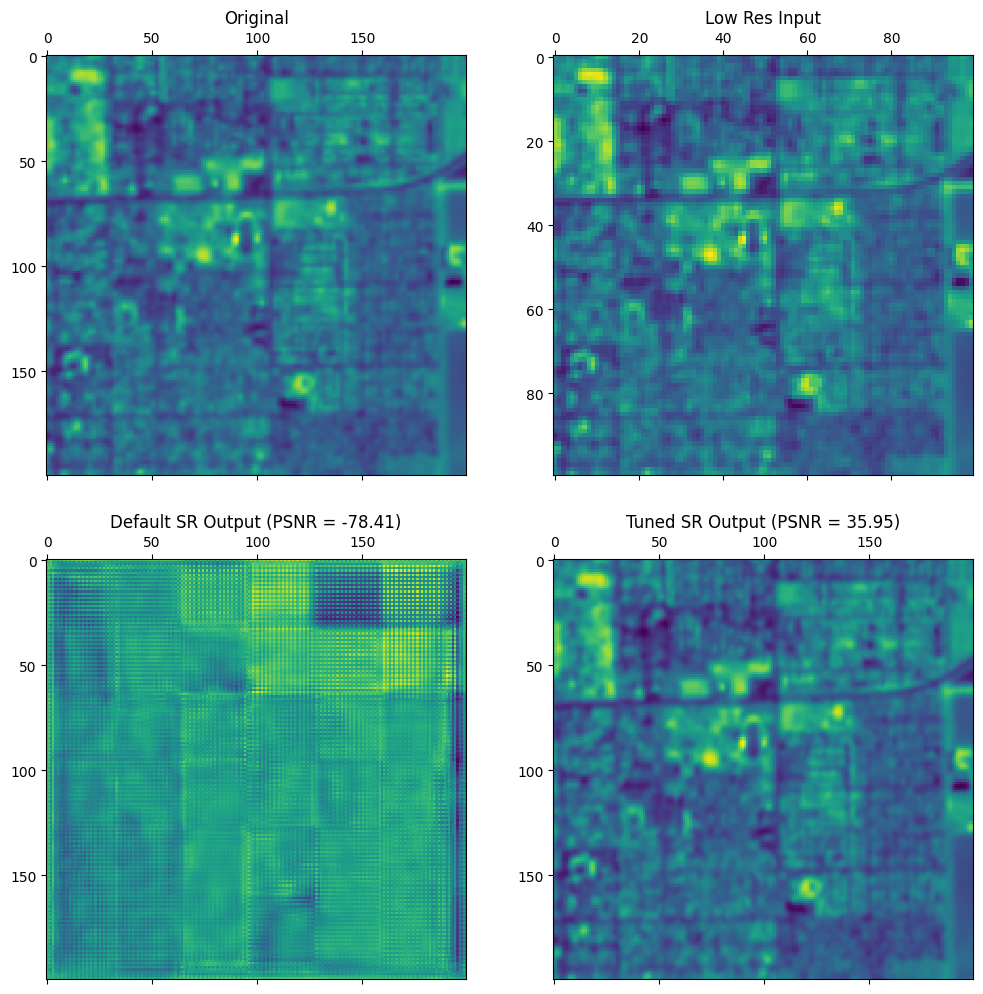

In [23]:
import models.ninab1
from utils.params import Params
from torchvision import transforms

# First, use the original image as the HR ground truth and create a LR version as input to the model. The output can then be compared to the original. 
# do this for both the untuned default Ninab1 model and the one that has been fine-tuned.

#Choose model, hparams, and device
model_file = "ninab1_v5"
params = Params("saved_models/" + model_file + "_hparams.yaml", "DEFAULT")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
trans = transforms.Compose([
    transforms.ToTensor()])

#Load the model
ninab1_model = models.ninab1.net(params).to(device)
ninab1_model.load_state_dict(torch.load("saved_models/" + model_file + ".ckpt"))
ninab1_model = ninab1_model.float()
ninba1_model.eval()

#Test it
input_lr = (lr - np.min(lr)) / (np.max(lr) - np.min(lr)) #normalize [0, 1]
hr = (hr - np.min(hr)) / (np.max(hr) - np.min(hr))
input_lr = trans(input_lr).float()
sr = model(input_lr).detach().numpy().reshape((3, 200, 200))

fig, ax = plt.subplots(2, 2)
ax[0, 0].matshow(hr)
ax[0, 0].set_title("Original")
ax[0, 1].matshow(lr)
ax[0, 1].set_title("Low Res Input")
ax[1, 0].matshow(nina_out[0, :, :])
ax[1, 0].set_title("Default SR Output (PSNR = " + str(round(psnr(hr, nina_out[0, :, :], ), 2))+")")
ax[1, 1].matshow(sr[0, :, :])
ax[1, 1].set_title("Tuned SR Output (PSNR = " + str(round(psnr(hr, sr[0, :, :], ), 2))+")")

Text(0.5, 1.0, 'SR on HR Image')

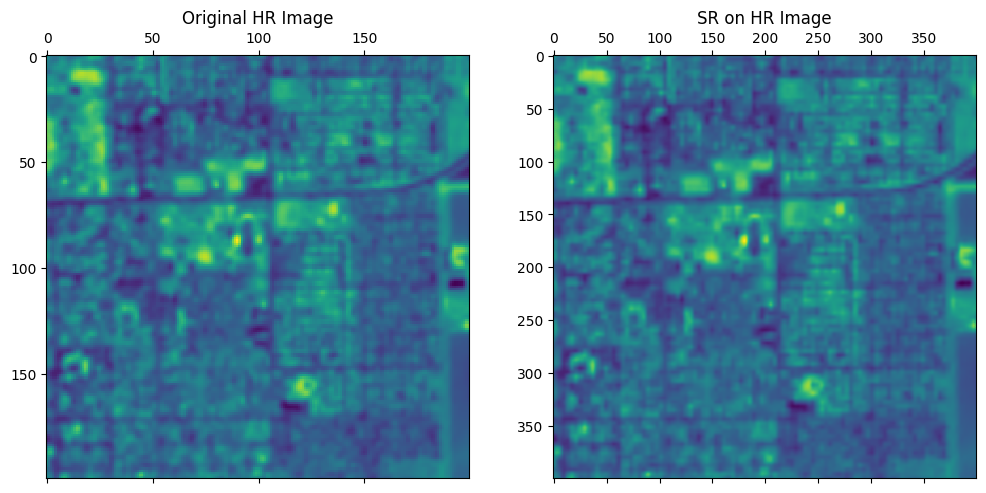

In [24]:
#Now test it on the original image to see if there is improvement

input_hr = trans(hr).float()
sr = ninab1_model(input_hr).detach().numpy().reshape((3, 400, 400))[0, :, :]
fig, ax = plt.subplots(1, 2)
ax[0].matshow(input_hr.reshape(200, 200))
ax[0].set_title("Original HR Image")
ax[1].matshow(sr.reshape(400, 400))
ax[1].set_title("SR on HR Image")

<h3>RCAN</h3>

(3, 200, 200)


Text(0.5, 1.0, 'Tuned SR Output (PSNR = 36.49)')

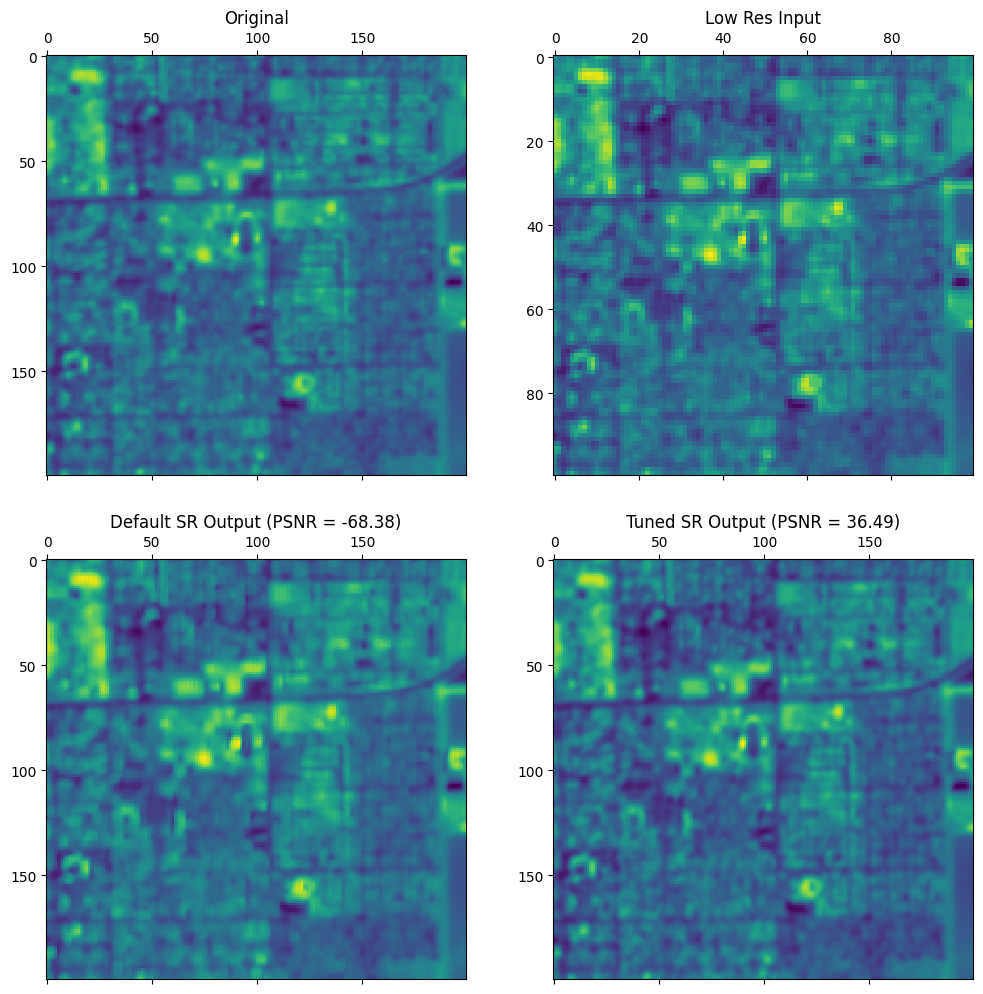

In [27]:
import models.rcan
from utils.params import Params
from torchvision import transforms

# First, use the original image as the HR ground truth and create a LR version as input to the model. The output can then be compared to the original. 
# do this for both the untuned default RCAN model and the one that has been fine-tuned.

#Choose model, hparams, and device
model_file = "rcan_v0"
params = Params("saved_models/" + model_file + "_hparams.yaml", "DEFAULT")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
trans = transforms.Compose([
    transforms.ToTensor()])

#Load the model
rcan_model = models.rcan.net(params).to(device)
rcan_model.load_state_dict(torch.load("saved_models/" + model_file + ".ckpt"))
rcan_model = rcan_model.float()
rcan_model.eval()

#Test it
input_lr = (lr - np.min(lr)) / (np.max(lr) - np.min(lr)) #normalize [0, 1]
hr = (hr - np.min(hr)) / (np.max(hr) - np.min(hr))
input_lr = trans(input_lr).float()
sr = rcan_model(input_lr).squeeze(0).detach().numpy()
print(sr.shape)

fig, ax = plt.subplots(2, 2)
ax[0, 0].matshow(hr)
ax[0, 0].set_title("Original")
ax[0, 1].matshow(lr)
ax[0, 1].set_title("Low Res Input")
ax[1, 0].matshow(edsr_out[0, :, :])
ax[1, 0].set_title("Default SR Output (PSNR = " + str(round(psnr(hr, rcan_out[0, :, :], ), 2))+")")
ax[1, 1].matshow(sr[0, :, :])
ax[1, 1].set_title("Tuned SR Output (PSNR = " + str(round(psnr(hr, sr[0, :, :], ), 2))+")")

Text(0.5, 1.0, 'SR on HR Image')

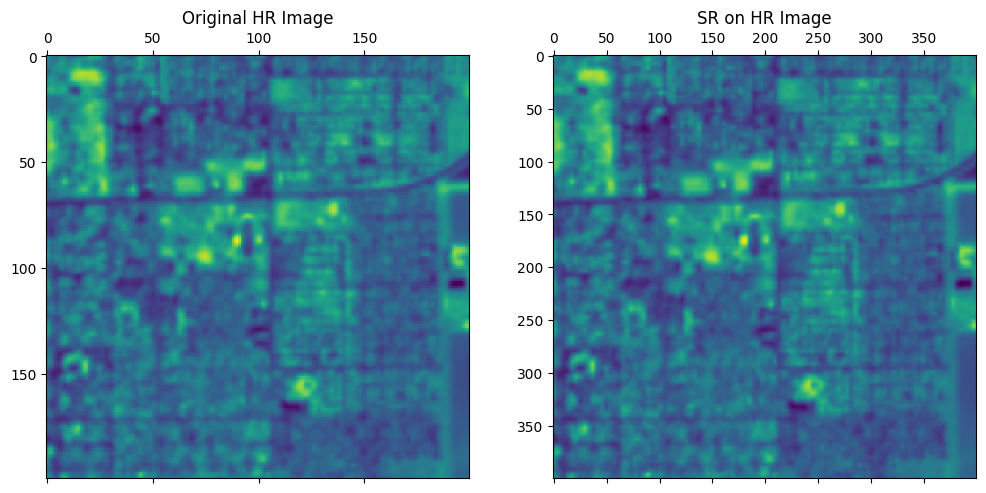

In [28]:
#Now test it on the original image to see if there is improvement

input_hr = trans(hr).float()
sr = rcan_model(input_hr).detach().numpy().reshape((3, 400, 400))[0, :, :]
fig, ax = plt.subplots(1, 2)
ax[0].matshow(input_hr.reshape(200, 200))
ax[0].set_title("Original HR Image")
ax[1].matshow(sr.reshape(400, 400))
ax[1].set_title("SR on HR Image")

<h3>EDSR</h3>

(3, 200, 200)


Text(0.5, 1.0, 'Tuned SR Output (PSNR = 36.49)')

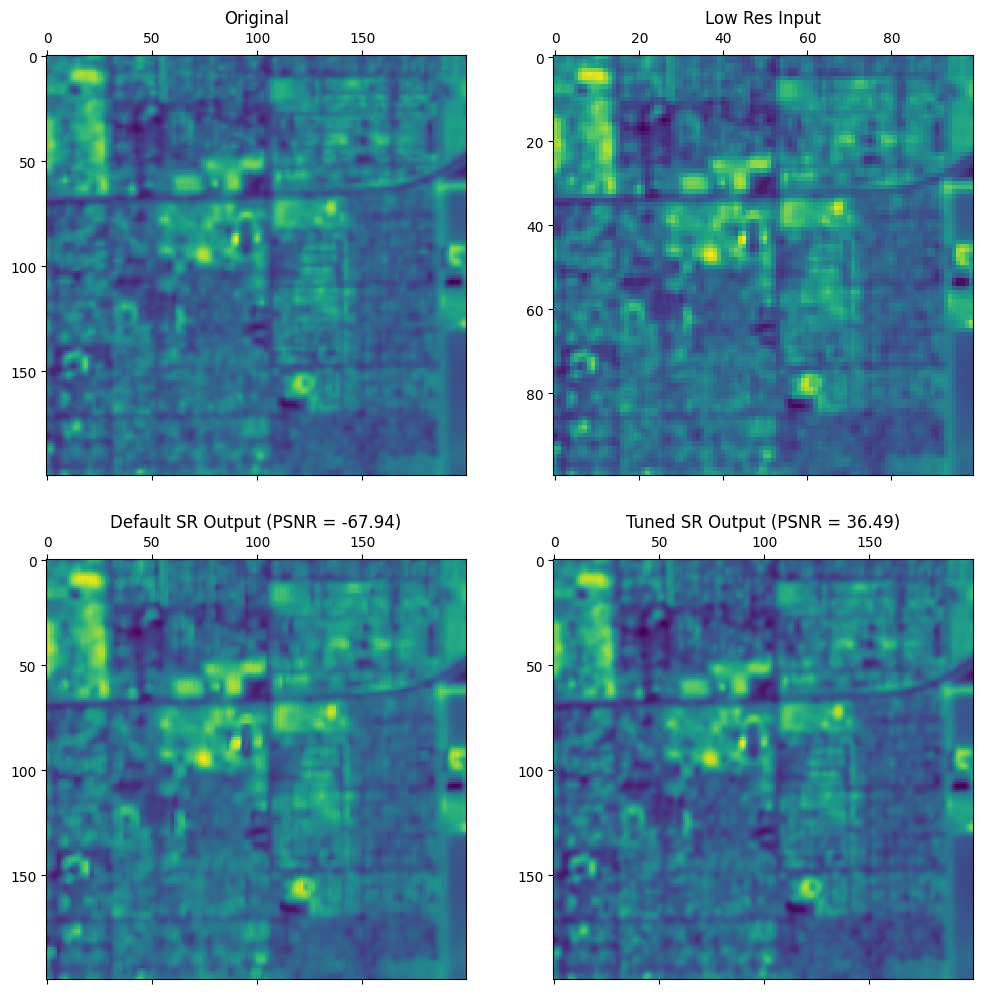

In [29]:
import models.edsr
from utils.params import Params
from torchvision import transforms

# First, use the original image as the HR ground truth and create a LR version as input to the model. The output can then be compared to the original. 
# do this for both the untuned default EDSR model and the one that has been fine-tuned.

#Choose model, hparams, and device
model_file = "edsr_v0"
params = Params("saved_models/" + model_file + "_hparams.yaml", "DEFAULT")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
trans = transforms.Compose([
    transforms.ToTensor()])

#Load the model
edsr_model = models.edsr.net(params).to(device)
edsr_model.load_state_dict(torch.load("saved_models/" + model_file + ".ckpt"))
edsr_model = edsr_model.float()
edsr_model.eval()

#Test it
input_lr = (lr - np.min(lr)) / (np.max(lr) - np.min(lr)) #normalize [0, 1]
hr = (hr - np.min(hr)) / (np.max(hr) - np.min(hr))
input_lr = trans(input_lr).float()
sr = edsr_model(input_lr).squeeze(0).detach().numpy()
print(sr.shape)

fig, ax = plt.subplots(2, 2)
ax[0, 0].matshow(hr)
ax[0, 0].set_title("Original")
ax[0, 1].matshow(lr)
ax[0, 1].set_title("Low Res Input")
ax[1, 0].matshow(edsr_out[0, :, :])
ax[1, 0].set_title("Default SR Output (PSNR = " + str(round(psnr(hr, edsr_out[0, :, :], ), 2))+")")
ax[1, 1].matshow(sr[0, :, :])
ax[1, 1].set_title("Tuned SR Output (PSNR = " + str(round(psnr(hr, sr[0, :, :], ), 2))+")")

Text(0.5, 1.0, 'SR on HR Image')

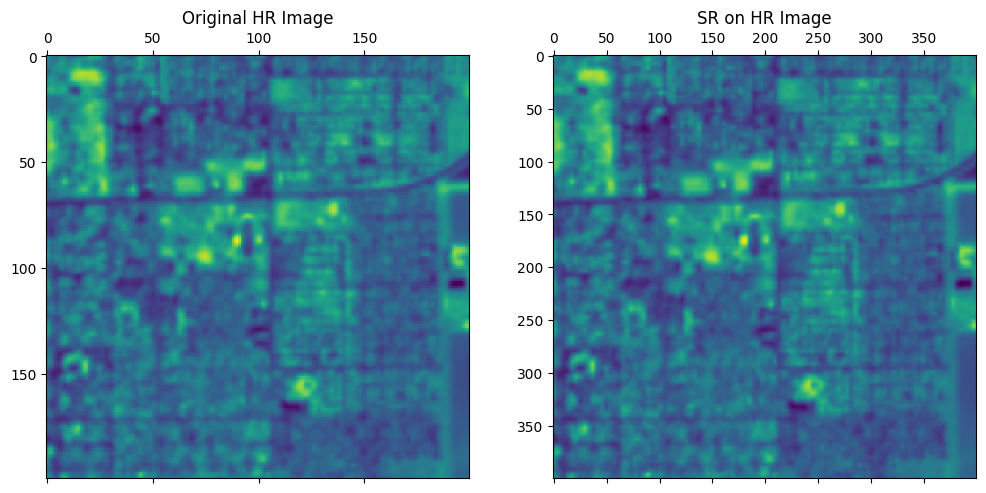

In [30]:
#Now test it on the original image to see if there is improvement

input_hr = trans(hr).float()
sr = edsr_model(input_hr).detach().numpy().reshape((3, 400, 400))[0, :, :]
fig, ax = plt.subplots(1, 2)
ax[0].matshow(input_hr.reshape(200, 200))
ax[0].set_title("Original HR Image")
ax[1].matshow(sr.reshape(400, 400))
ax[1].set_title("SR on HR Image")

<h1>Side-by-Side Comparison</h1>

In [2]:
from torchvision import transforms
from utils.params import Params
import models.rcan
import models.ninab1
import models.ninab2
import models.edsr

trans = transforms.Compose([
    transforms.ToTensor()])

# --- Ninab1 model ---
model_file = "ninab1_v5"
params = Params("saved_models/" + model_file + "_hparams.yaml", "DEFAULT")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#Load the model
ninab1_model = models.ninab1.net(params).to(device)
ninab1_model.load_state_dict(torch.load("saved_models/" + model_file + ".ckpt"))
ninab1_model = ninab1_model.float()
ninab1_model.eval()

# --- Ninab2 model ---
model_file = "ninab2_v0"
params = Params("saved_models/" + model_file + "_hparams.yaml", "DEFAULT")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#Load the model
ninab2_model = models.ninab2.net(params).to(device)
ninab2_model.load_state_dict(torch.load("saved_models/" + model_file + ".ckpt"))
ninab2_model = ninab2_model.float()
ninab2_model.eval()

# --- RCAN model ---
model_file = "rcan_v0"
params = Params("saved_models/" + model_file + "_hparams.yaml", "DEFAULT")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#Load the model
rcan_model = models.rcan.net(params).to(device)
rcan_model.load_state_dict(torch.load("saved_models/" + model_file + ".ckpt"))
rcan_model = rcan_model.float()
rcan_model.eval()

# --- EDSR model ---
model_file = "edsr_v0"
params = Params("saved_models/" + model_file + "_hparams.yaml", "DEFAULT")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#Load the model
edsr_model = models.edsr.net(params).to(device)
edsr_model.load_state_dict(torch.load("saved_models/" + model_file + ".ckpt"))
edsr_model = edsr_model.float()
edsr_model.eval()

# --- EDSR model ---
model_file = "edsr_v1"
params = Params("saved_models/" + model_file + "_hparams.yaml", "DEFAULT")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#Load the model
edsr_model2 = models.edsr.net(params).to(device)
edsr_model2.load_state_dict(torch.load("saved_models/" + model_file + ".ckpt"))
edsr_model2 = edsr_model2.float()
edsr_model2.eval()

net(
  (model): EDSR(
    (sub_mean): MeanShift(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (add_mean): MeanShift(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (head): Sequential(
      (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (body): Sequential(
      (0): ResBlock(
        (body): Sequential(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (1): ResBlock(
        (body): Sequential(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (2): ResBlock(
        (body): Sequential(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2)

In [4]:
from tqdm import tqdm
from torchvision import transforms
from utils.params import Params
import models.rcan
import models.ninab1
import models.ninab2
import models.edsr

#Setup
model_dict = {
    "edsr": models.edsr,
    "rcan": models.rcan,
    "ninab1": models.ninab1,
    "ninba2": models.ninab2
}
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
trans = transforms.Compose([
    transforms.ToTensor()])

#Controls for visualisation
channels = range(3, 5)
model_files = ["edsr_v0", "edsr_v1"]

models = [] #array of model objects
for model_file in model_files:
    model_type = model_file[:model_file.find("_")]
    model_shell = model_dict[model_type]
    params = Params("saved_models/" + model_file + "_hparams.yaml", "DEFAULT")
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    models.append(model_shell.net(params).to(device).load_state_dict(torch.load("saved_models/" + model_file + ".ckpt")))
    

plt.rcParams['figure.figsize'] = [4 * (len(models) + 1), 4 * len(channels)]
fig, ax = plt.subplots(len(channels), len(models)+1, sharex=True, sharey=True)
plt.figure(dpi=100)
fig.subplots_adjust(hspace=0.05, wspace=0.05)
#fig.tight_layout()

path = "../Dataset/Raw/sentinel-2/06-001-0007/S2B_MSIL2A_20210911T184929_N0301_R113_T10SFG_20210911T214647.npy"
im = np.load(path).astype("double")
for channel_index, channel in enumerate(channels):
    #Prepare input image
    hr = im[:, :, channel_index]
    hr = (hr - np.min(hr)) / (np.max(hr) - np.min(hr))
    input_hr = trans(hr).float()

    #Plot the SRs and the HR image
    for model_index, model in enumerate(models):
        sr = model(input_hr).detach().numpy().reshape((3, 400, 400))[0, :, :]
        ax[channel_index][model_index].imshow(sr)

        #Set the model labels
        if channel_index == 0:
            ax[0][model_index].set_xlabel(model_files[model_index])
            ax[0][model_index].xaxis.set_label_position('top')

        #Clear tick labels for all plots
        ax[channel_index][model_index].set_xticklabels([])
        ax[channel_index][model_index].set_yticklabels([])
    
    #Also plot the original
    ax[channel_index][len(models)].imshow(hr)

    #Channel titles
    ax[channel_index][0].set_ylabel(channel)

plt.show()


AttributeError: module 'models' has no attribute 'ninba2'